Use the QQQ 1-minute data

Implement an oscillator indicator derived from a deep learning model to determine if profitable pivot points (i.e., a higher low and higher high for uptrends (HL,HH), and lower high and lower low (LH,LL) for downtrends) can be detected by taking into account multiple timeframe contexts (e.g., 1, 2, 5, 15, 60 minute charts).

Using a HL,HH / LH,LL lagging indicator ("price action" indicator), train a model to predict the most and least profitable opening position entry points at the time horizon by looking at best and worst case returns for all intraday 1-minute uptrend and downtrend breakouts prior to closing. The model should take into account the 1-minute intraday session time and higher timeframe linear regressions (2, 5, 15, 60 minutes) or other trend indicators. 

Uptrends are defined as a HL + HH. The "HH" is set once the price exceeds the prior price high that would be above the HL's price.

Downtrends are defined as a LH + LL. The "LL" is set once the price is below the prior low's price, which would be below the LH's price.

An example Tradingview indicator using a price action indicator: https://www.tradingview.com/script/vcg3prja/

The model should output an oscillator that has a sigmoid-like characteristic that sways toward 0 or 1 based on the strength of the forecast indicating an expected best- (positive) or worst-case return (negative).

The model can employ a lookahead during training, especially since price action type indicators are lagging indicators.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn import svm
from sklearn.metrics import accuracy_score

2023-07-14 01:43:54.917214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('QQQ_1_minute.csv')

In [3]:
data['HH'] = np.where(data['High'] > data['High'].shift(1), 1, 0)
data['HL'] = np.where(data['Low'] > data['Low'].shift(1), 1, 0)
data['LH'] = np.where(data['High'] < data['High'].shift(1), 1, 0)
data['LL'] = np.where(data['Low'] < data['Low'].shift(1), 1, 0)
data['Action'] = np.where(data['HH'] + data['HL'] == 2, 1 , np.where(data['LH'] + data['LL'] == 2, -1 ,0))
data['Action'] = data['Action'].shift(1)

In [4]:
data['Date']=pd.to_datetime(data['DateTime']).dt.date

In [5]:
def DailyReturn(d):
    returns = []
    lindex=d.index[-1]
    for i, _ in d.iterrows():
        onereturn = float((d.loc[lindex, 'Close']-d.loc[i, 'Close']) / d.loc[i, 'Close'])
        returns.append(onereturn)
    return returns

In [ ]:
datanew = pd.DataFrame()
for i in data['Date'].unique():
    datedata = data[data['Date']== i]
    datedata['Action'][0] = None
    returns = DailyReturn(datedata)
    datedata['Returns'] = returns * datedata['Action']
    datedata = datedata[datedata['Action'] != 0]
    datedata = datedata[datedata['Action'].notnull()]
    datedata['Percent'] = (datedata['Returns']-datedata['Returns'].min())/(datedata['Returns'].max()-datedata['Returns'].min())
    datanew = pd.concat([datanew, datedata])

In [7]:
for i, _ in data.iterrows():
    if i in datanew.index:
        data.loc[i, 'AAction'] = datanew.loc[i, 'Action']
    else:
        data.loc[i, 'AAction'] = 0

In [8]:
data['Buy'] = np.where(data['AAction'] == 1, data['Close'], np.nan)
data['Sell'] = np.where(data['AAction'] == -1, data['Close'], np.nan)

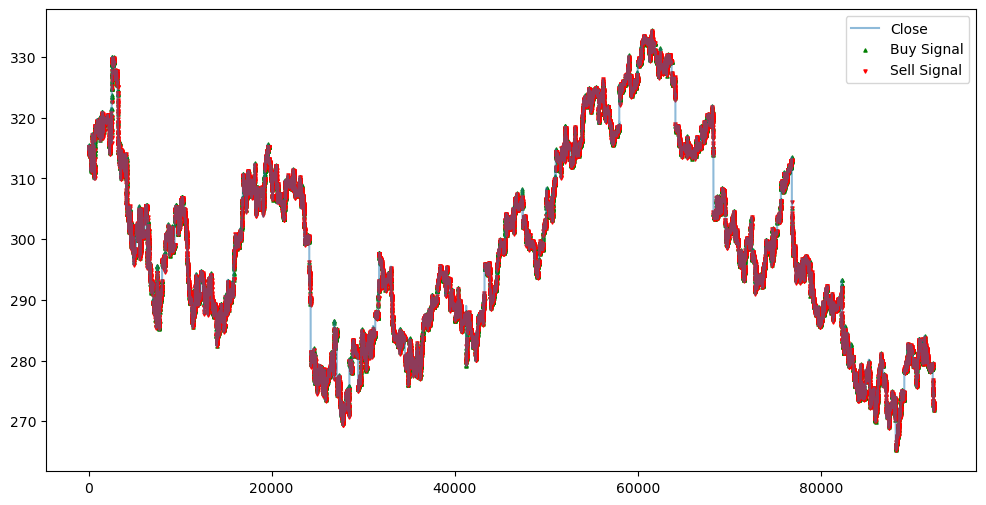

In [9]:
plt.figure(figsize=(12, 6)) 
plt.plot(data['Close'], label = 'Close', alpha = 0.5)
plt.scatter(data.index, data['Buy'], color = 'green', label = 'Buy Signal', marker= '^', s = 5)
plt.scatter(data.index, data['Sell'], color = 'red', label = 'Sell Signal', marker= 'v', s = 5)
plt.legend()
plt.show()

In [10]:
datanew['Max/Min'] = np.where(datanew['Percent'] == 1, 1, np.where(datanew['Percent'] == -1, -1, 0))

In [11]:
features = ['Open', 'High', 'Low', 'Close']  # Features to be used for training
scaler = MinMaxScaler() 
X = datanew[features]
X = scaler.fit_transform(X)
y = datanew['Max/Min']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 

In [12]:
svm_linear=svm.SVC(kernel="linear", class_weight = 'balanced', probability = True, decision_function_shape="ovr")
svm_linear.fit(X_train,y_train)

SVC(class_weight='balanced', kernel='linear', probability=True)

In [17]:
newdata=datanew

In [18]:
newdata['Predictions_SVM'] = svm_linear.predict(scaler.transform(newdata[features]))

In [19]:
datanew['Max/Min'] = np.where(datanew['Percent'] == 1, 1, np.where(datanew['Percent'] == -1, 0, np.nan))
dd=datanew.dropna()
X = dd[features]
X = scaler.transform(X)
y = dd['Max/Min']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)  # Split the data into training and validation sets
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

2023-07-14 01:55:26.624208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
3/3 [==============================] - 1s 77ms/step - loss: 0.6541 - val_loss: 0.6257
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6056 - val_loss: 0.5829
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5611 - val_loss: 0.5425
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5189 - val_loss: 0.5036
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4788 - val_loss: 0.4672
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4419 - val_loss: 0.4330
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4064 - val_loss: 0.3995
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.3724 - val_loss: 0.3669
Epoch 9/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3395 - val_loss: 0.3352
Epoch 10/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3078 - val_loss: 0.3045
Epoch 11/100
3/3 [=

In [20]:
newdata['score1'] = model.predict(scaler.transform(newdata[features]))
newdata['Prediction_LogisticR'] = np.where(newdata['score1'] > np.percentile(newdata['score1'],90), 1, np.where(newdata['score1'] < np.percentile(newdata['score1'],10), -1, 0))

1863/1863 [==============================] - 2s 765us/step


In [21]:
X = datanew[features]
X = scaler.transform(X)
y = datanew['Percent']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 

In [22]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError())
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0649 - val_loss: 0.0632
Epoch 2/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0642 - val_loss: 0.0632
Epoch 3/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0642 - val_loss: 0.0628
Epoch 4/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0642 - val_loss: 0.0629
Epoch 5/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0642 - val_loss: 0.0629
Epoch 6/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0642 - val_loss: 0.0628
Epoch 7/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0642 - val_loss: 0.0628
Epoch 8/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0642 - val_loss: 0.0628
Epoch 9/100
1490/1490 [==============================] - 2s 1ms/step - loss: 0.0641 - val_loss: 0.0628
Epoch 10/100
1490/1490 [==============================] - 2s 1ms/step - l

In [23]:
newdata['score2'] = model.predict(scaler.transform(newdata[features]))
newdata['Prediction_LinearR'] = np.where(newdata['score2'] > np.percentile(newdata['score2'],90), 1, np.where(newdata['score2'] < np.percentile(newdata['score2'],10), -1, 0))

1863/1863 [==============================] - 1s 760us/step


In [25]:
newdata

,DateTime,Open,High,Low,Close,HH,HL,LH,LL,Action,Date,Returns,Percent,Max/Min,Predictions_SVM,score1,Prediction_LogisticR,score2,Prediction_LinearR
2,2022-05-02 08:02:00,315.16,315.18,314.00,314.96,0,0,0,1,1.0,2022-05-02,0.009874,0.700783,NaN,0,0.999967,0,0.515679,0
4,2022-05-02 08:04:00,315.21,315.31,315.08,315.14,1,1,0,0,1.0,2022-05-02,0.009297,0.689525,NaN,0,0.999968,0,0.516759,0
5,2022-05-02 08:05:00,315.14,315.18,314.98,314.99,0,0,1,1,1.0,2022-05-02,0.009778,0.698906,NaN,0,0.999967,0,0.516927,0
6,2022-05-02 08:06:00,314.99,315.07,314.80,314.80,0,0,1,1,-1.0,2022-05-02,-0.010388,0.305336,NaN,0,0.999967,0,0.516945,0
7,2022-05-02 08:07:00,314.80,315.10,314.80,315.08,1,0,0,0,-1.0,2022-05-02,-0.009490,0.322860,NaN,0,0.999967,0,0.516309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92375,2022-10-07 14:55:00,272.71,272.94,272.54,272.83,1,1,0,0,1.0,2022-10-07,-0.001503,0.474965,NaN,0,0.997676,-1,0.504603,-1
92376,2022-10-07 14:56:00,272.83,273.04,272.75,272.80,1,1,0,0,1.0,2022-10-07,-0.001393,0.477119,NaN,0,0.997703,-1,0.504843,-1
92377,2022-10-07 14:57:00,272.80,272.80,272.52,272.57,0,0,1,1,1.0,2022-10-07,-0.000550,0.493649,NaN,0,0.997658,-1,0.504585,-1
92378,2022-10-07 14:58:00,272.57,272.62,272.34,272.42,0,0,1,1,-1.0,2022-10-07,-0.000000,0.504445,NaN,0,0.997613,-1,0.504166,-1
